 World boundary loaded from GitHub GeoJSON
 Elasticity aligned to HydroATLAS: 4,346 rows
 Valid stations after QC: 4,346


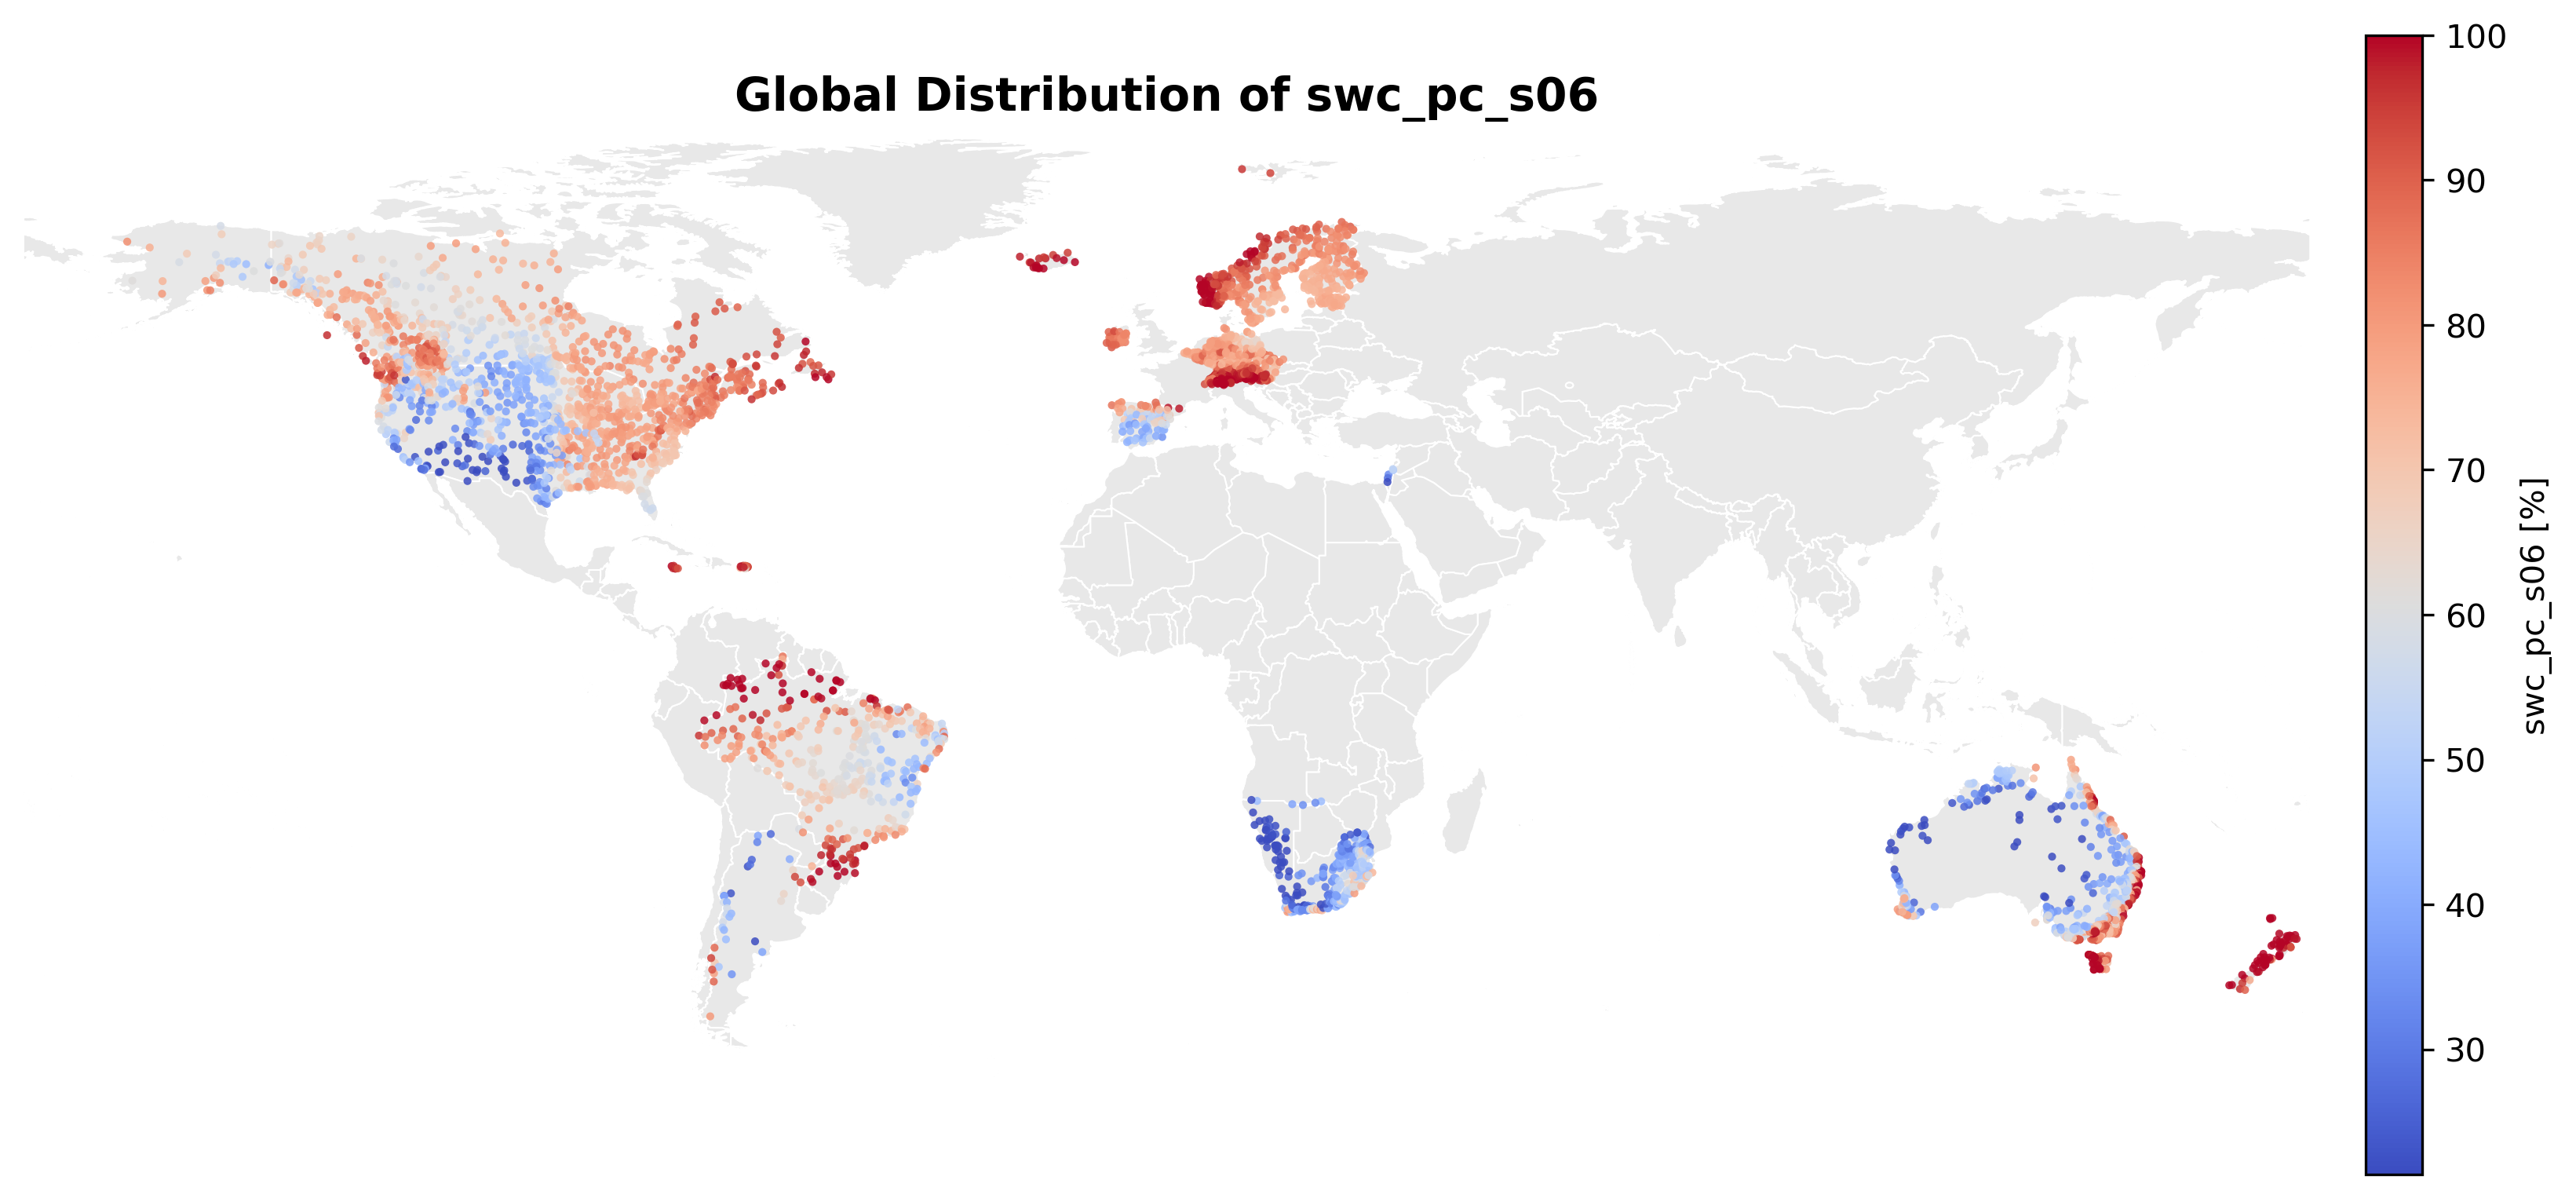

 Saved: global_swc_pc_s06.(png) -> outputs_maps


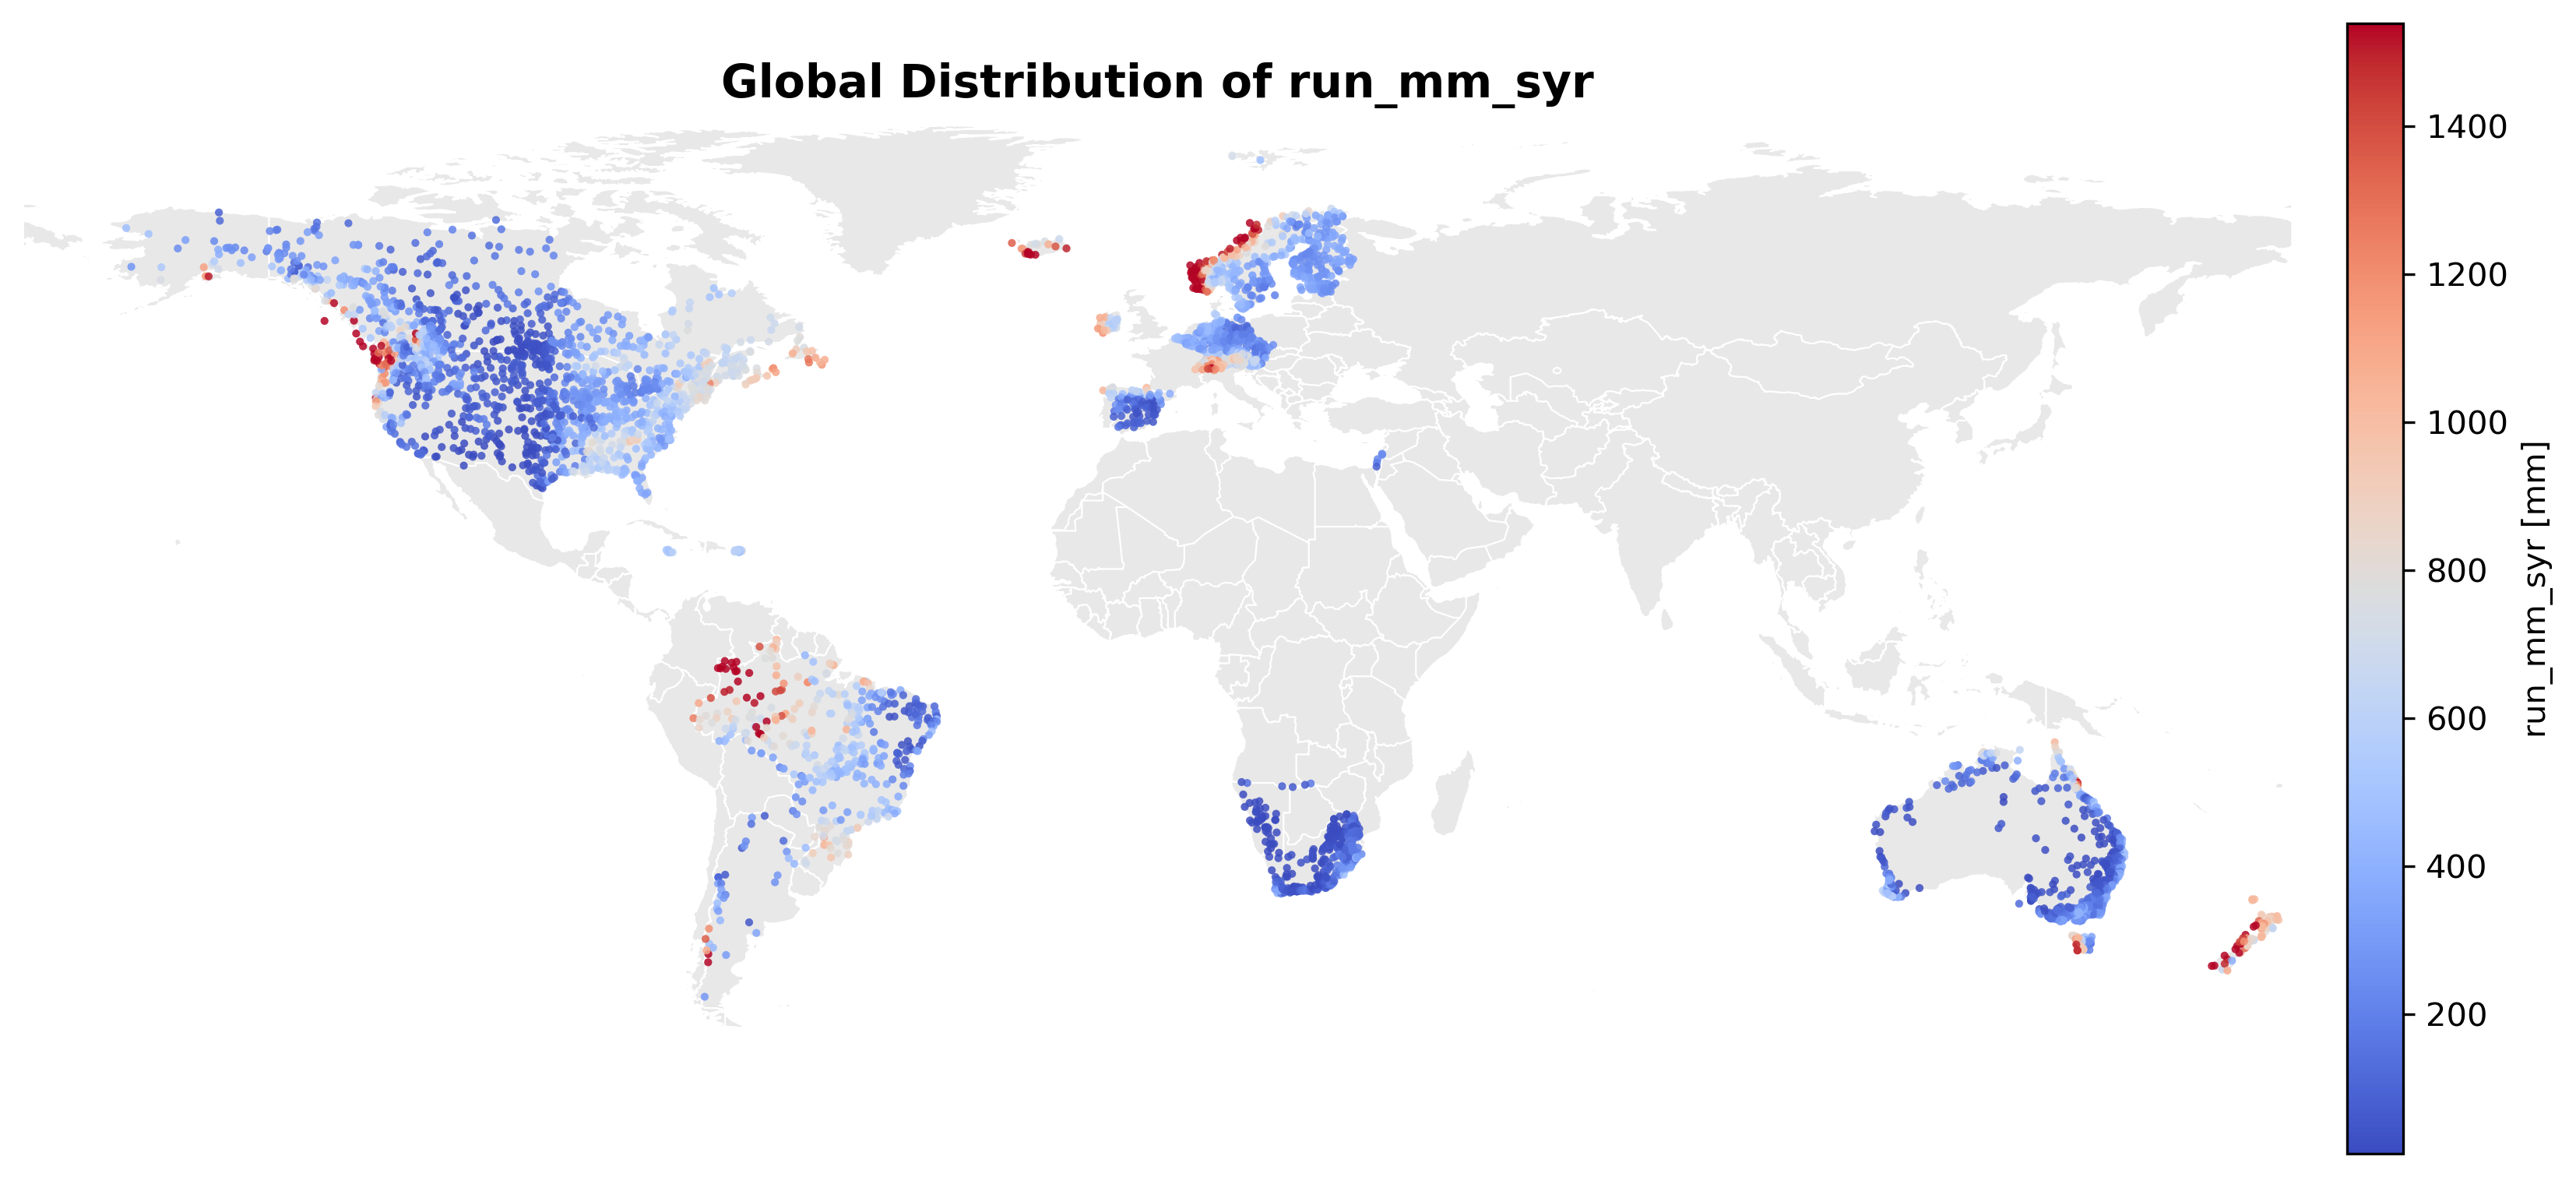

 Saved: global_run_mm_syr.(png) -> outputs_maps


In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path

BASE = Path(".")
ELASTICITY_CSV = BASE / "./elasticity_gls2_cleaned.csv" 
HYDROATLAS_CSV = BASE / "attributes/grdc/attributes_hydroatlas_grdc.csv" 
COORDS_CSV     = BASE / "attributes/grdc/attributes_other_grdc.csv"


RIVERS_PATH  = None 
KOPPEN_PATH  = None
KOPPEN_FIELD = None

OUTDIR = BASE / "outputs_maps"
OUTDIR.mkdir(parents=True, exist_ok=True)


EXTENT = (-180, 180, -60, 85)   # xmin, xmax, ymin, ymax
CMAP   = "coolwarm"             # Low=Blue, High=Red
PCLIP  = (2, 98)                # Colour coded 2-98 minute cut-offs
MSIZE  = 6
ALPHA  = 0.85
DPI    = 300


def load_world_from_web():
    url = "https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson"
    try:
        world = gpd.read_file(url)
        name_col = "name" if "name" in world.columns else None
        if name_col:
            world = world[world[name_col] != "Antarctica"]
        print(" World boundary loaded from GitHub GeoJSON")
        return world
    except Exception as e:
        print(f" World boundary load failed ({e}); will plot points without basemap.")
        return None

def robust_limits(series, pclip=(2, 98)):
    s = series[np.isfinite(series)]
    if s.empty:
        return None, None
    vmin, vmax = np.nanpercentile(s, list(pclip))
    if np.isclose(vmin, vmax):
        vmin, vmax = float(s.min()), float(s.max())
    return vmin, vmax

def synthesize_coords(n):
    np.random.seed(42)
    lats, lons = [], []
    lats.extend(np.random.normal(45, 10, n//6));  lons.extend(np.random.normal(-100, 20, n//6))  
    lats.extend(np.random.normal(50,  8, n//8));  lons.extend(np.random.normal(10,   15, n//8))  
    lats.extend(np.random.normal(35, 15, n//4));  lons.extend(np.random.normal(110,  25, n//4))  
    lats.extend(np.random.normal(-10,15, n//8));  lons.extend(np.random.normal(-60,  15, n//8))  
    lats.extend(np.random.normal(0,  20, n//10)); lons.extend(np.random.normal(20,   15, n//10)) 
    lats.extend(np.random.normal(-25, 5, n//15)); lons.extend(np.random.normal(135,  10, n//15)) 
    remain = n - len(lats)
    if remain > 0:
        lats.extend(np.random.uniform(-60, 70, remain))
        lons.extend(np.random.uniform(-180, 180, remain))
    lats = np.clip(lats[:n], -60, 80)
    lons = np.clip(lons[:n], -180, 180)
    return lats, lons

def build_merged_gdf(elasticity_csv, hydroatlas_csv, coords_csv):
    elas  = pd.read_csv(elasticity_csv)   
    attrs = pd.read_csv(hydroatlas_csv)   
    df = attrs.merge(elas, left_on="gauge_id", right_on="station_id", how="inner")
    print(f" Elasticity aligned to HydroATLAS: {len(df):,} rows")

    have_coords = coords_csv.exists()
    if have_coords:
        coords = pd.read_csv(coords_csv)
        need = {"gauge_id","gauge_lon","gauge_lat"}
        if need.issubset(coords.columns):
            df = df.merge(coords[list(need)], on="gauge_id", how="left")
        else:
            have_coords = False

    if not have_coords or df[["gauge_lon","gauge_lat"]].isna().all().all():
        # synthetic coordinates
        print(" No valid coordinates found; synthesizing coordinates for demo...")
        lats, lons = synthesize_coords(len(df))
        df["gauge_lat"] = lats
        df["gauge_lon"] = lons

    # Filtering illegal coordinates
    m = (
        np.isfinite(df["gauge_lon"]) & np.isfinite(df["gauge_lat"]) &
        df["gauge_lon"].between(-180, 180) & df["gauge_lat"].between(-90, 90)
    )
    df = df[m].copy()
    print(f" Valid stations after QC: {len(df):,}")

    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df["gauge_lon"], df["gauge_lat"]),
        crs="EPSG:4326"
    )
    return df, gdf


def plot_var_map(
    gdf, var, unit, out_prefix,
    world=None, rivers=None, koppen=None, koppen_field=None,
    extent=EXTENT, cmap=CMAP, pclip=PCLIP, msize=MSIZE, alpha=ALPHA, dpi=DPI
):
    if var not in gdf.columns:
        print(f"[Skip] Missing column: {var}")
        return
    sub = gdf[np.isfinite(gdf[var])].copy()
    if sub.empty:
        print(f"[Skip] {var} has no valid data")
        return

    vmin, vmax = robust_limits(sub[var], pclip=pclip)

    fig, ax = plt.subplots(figsize=(12, 6.75), dpi=dpi)

    # Background map
    if world is not None:
        try:
            world.plot(ax=ax, facecolor="#e8e8e8", edgecolor="white", linewidth=0.5, zorder=0)
        except Exception as e:
            print(f" Basemap draw failed: {e}")


    # website
    sub.plot(
        ax=ax, column=var, cmap=cmap, markersize=msize, alpha=alpha, edgecolor="none",
        vmin=vmin, vmax=vmax, legend=False, zorder=2
    )

    # Colour bar
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    cbar = fig.colorbar(sm, ax=ax, shrink=0.75, pad=0.02)
    cbar.set_label(f"{var} [{unit}]")

    
    xmin, xmax, ymin, ymax = extent
    ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
    ax.axis("off")
    ax.set_title(f"Global Distribution of {var}", fontsize=14, fontweight="bold")
    fig.tight_layout()

    
    for fmt in ["png"]:
        fig.savefig(OUTDIR / f"{out_prefix}.{fmt}", bbox_inches="tight")
    plt.show()
    print(f" Saved: {out_prefix}.(png) -> {OUTDIR}")


def main():
    # World boundaries
    world = load_world_from_web()

    # Data alignment + coordinates
    df, gdf = build_merged_gdf(ELASTICITY_CSV, HYDROATLAS_CSV, COORDS_CSV)
    # Reproduce merged table
    keep = ["gauge_id","station_id","gauge_lon","gauge_lat","swc_pc_s06","run_mm_syr","e_Q_P","e_Q_EP"]
    (gdf[[c for c in keep if c in gdf.columns]]
        .drop_duplicates()
        .to_csv(OUTDIR/"merged_for_maps.csv", index=False))

    # Two graphs: low = blue, high = red; colour bar labels units
    plot_var_map(gdf, "swc_pc_s06", "%",  "global_swc_pc_s06",
                 world=world, koppen_field=KOPPEN_FIELD)
    plot_var_map(gdf, "run_mm_syr",  "mm", "global_run_mm_syr",
                 world=world, koppen_field=KOPPEN_FIELD)

if __name__ == "__main__":
    main()
